**Whatsapp Group Chat Data Anaylyis**

by Yoihen Elangbam

Import Libraries

> I'll add the dependencies as a requirements.txt



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
!pip3 install -U kaleido
import kaleido
import re
from tabulate import tabulate
from collections import Counter
import collections
import datetime
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Transfer the data into a Dataframe

In [ ]:
# Read chat data from text file
with open('/content/_chat3.txt', 'r', encoding='utf-8') as f:
    chat_data = f.readlines()

# Define regular expressions to extract data
message_regex = re.compile(
    r'^\[(\d{2}/\d{2}/\d{2}), (\d{1,2}:\d{2}:\d{2}\s[AP]M)\] ([^:]+): (.+)$'
)

system_message_regex = re.compile(
    r'^\[(\d{2}/\d{2}/\d{2}), (\d{1,2}:\d{2}:\d{2}\s[AP]M)\] (.+)$'
)

dates = []
times = []
members = []
messages = []
message_types = []
message_lengths = []
reaction_counts = []
word_counts = []
hashtags = []
mentions = []

for line in chat_data:
    match = message_regex.match(line)
    if match:
        dates.append(match.group(1))  # dd/mm/yy
        times.append(match.group(2))   # hh:mm:ss AM/PM
        member = match.group(3).strip()
        members.append(member)
        messages.append(match.group(4))
        message_types.append('text')
        message_lengths.append(len(match.group(4)))
        reaction_counts.append(0)
        word_counts.append(len(match.group(4).split()))
        hashtags.append(re.findall(r'#(\w+)', match.group(4)))
        mentions.append(re.findall(r'@(\w+)', match.group(4)))
    else:
        match = system_message_regex.match(line)
        if match:
            dates.append(match.group(1))
            times.append(match.group(2))
            members.append('System')
            messages.append(match.group(3))
            message_types.append('system')
            message_lengths.append(len(match.group(3)))
            reaction_counts.append(0)
            word_counts.append(len(match.group(3).split()))
            hashtags.append([])
            mentions.append([])

df = pd.DataFrame({
    'date': dates,
    'time': times,
    'member': members,
    'message': messages,
    'message_type': message_types,
    'message_length': message_lengths,
    'reaction_count': reaction_counts,
    'word_count': word_counts,
    'hashtags': hashtags,
    'mentions': mentions,
})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256665 entries, 3 to 257647
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               256665 non-null  datetime64[ns]
 1   time               256665 non-null  object        
 2   member             256665 non-null  object        
 3   message            256665 non-null  object        
 4   message_type       256665 non-null  object        
 5   message_length     256665 non-null  int64         
 6   reaction_count     256665 non-null  int64         
 7   word_count         256665 non-null  int64         
 8   hashtags           256665 non-null  object        
 9   mentions           256665 non-null  object        
 10  words_per_message  256665 non-null  int64         
 11  links_per_message  256665 non-null  int64         
 12  sentiment          256665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), objec

In [ ]:
#removing first three rows because they are redundant
df = df.iloc[3:]

In [ ]:
#removing messages by group entity
df = df[(df['member'] != 'TCS (ಟಾಟಾ ಸಲಹಾ ಸೇವೆಗಳು)I') &
        (df['member'] != 'Ayush') &
        (df['member'] != '~\u202fKrishabh Garud') &
        (df['member'] != 'Mehul') &
        (df['member'] != '~\u202fKeshav') &
        (df['member'] != '~\u202fChetan Pandey') &
        (df['member'] !='\u200eYou')
        ]

In [ ]:
print('Shape of the Dataframe is',df.shape)

Shape of the Dataframe is (256665, 10)


In [ ]:
#defined a function to hide the member names
from change_names import replace_member_names

df = replace_member_names(df)

In [ ]:
df.head(1)

,date,time,member,message,message_type,message_length,reaction_count,word_count,hashtags,mentions,words_per_message,links_per_message,sentiment
3,2022-09-23,1:43:21 PM,John1,Yall going to check out that gaming thing sp me?,text,48,0,10,[],[],10,0,0.0


In [ ]:
df['member'].unique()

array(['John1', 'John2', 'John3', 'John4', 'John5', 'John6', 'John7',
       'John8', 'John9', 'John10', 'John11', 'John12', 'System messages',
       'Meta AI'], dtype=object)

Making a Dataframe for Individual Member Stats

In [ ]:
# messages sent per member
messages_sent = df.groupby('member')['message'].count()

# words per message
df['words_per_message'] = df['message'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
words_per_message = df.groupby('member')['words_per_message'].mean()

# links sent per message
df['links_per_message'] = df['message'].apply(lambda x: len(re.findall(r'http\S+', x)) if isinstance(x, str) else 0)
links_per_message = df.groupby('member')['links_per_message'].mean()

stats_df = pd.concat([messages_sent, words_per_message,  links_per_message], axis=1)
stats_df.columns = ['messages_sent', 'words_per_message', 'links_per_message']

stats_df = stats_df.sort_values('messages_sent', ascending=False)
stats_df

,messages_sent,words_per_message,links_per_message
member,,,
John10,60791,3.280321,0.005461
John4,36174,3.955134,0.008431
John5,35969,3.668242,0.003586
John1,26703,3.305996,0.004382
John2,22317,4.197876,0.002868
John3,20270,4.055501,0.003355
John6,14959,3.537937,0.018183
John8,12367,3.874020,0.000647
John9,10348,3.616158,0.005895


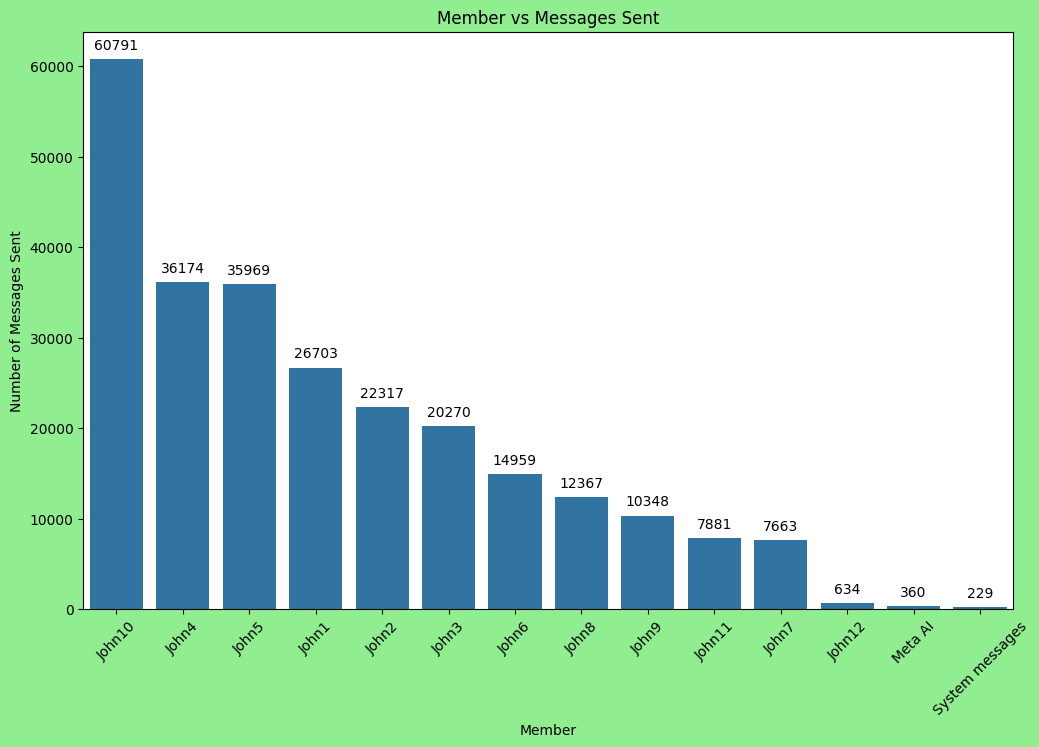

In [ ]:
plt.figure(figsize=(12, 7.5),facecolor='lightgreen')
ax = sns.barplot(x=stats_df.index, y=stats_df['messages_sent'])
plt.xticks(rotation=45)
plt.xlabel('Member')
plt.ylabel('Number of Messages Sent')
plt.title('Member vs Messages Sent')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.savefig('frequencyplot.png')
plt.show()

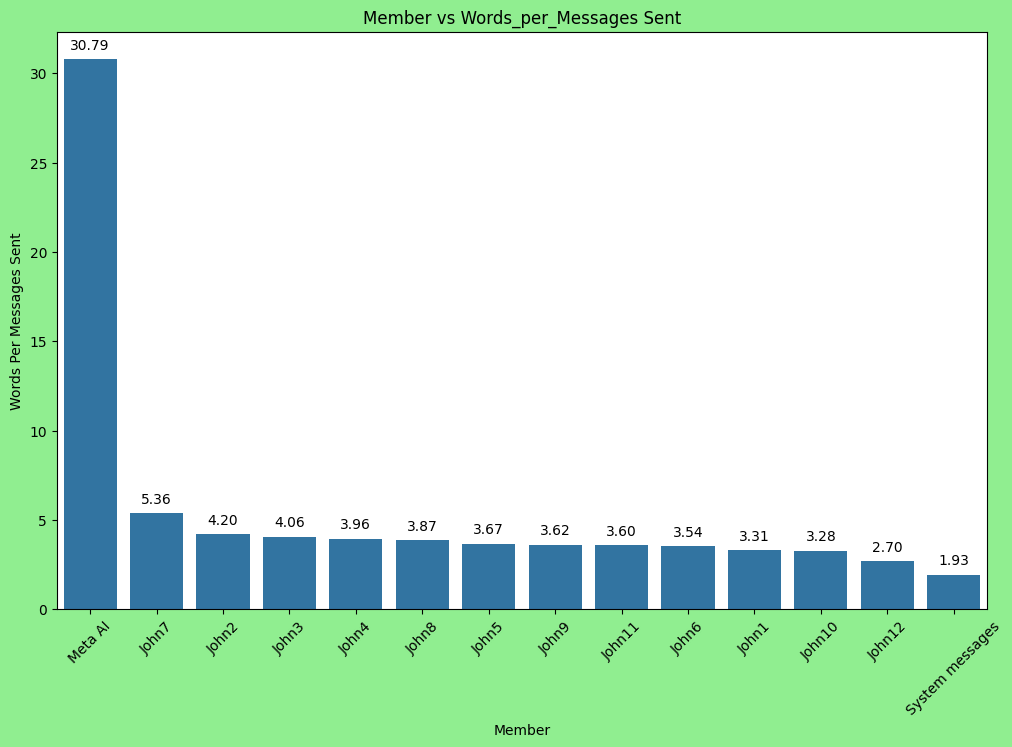

In [ ]:
plt.figure(figsize=(12, 7.5),facecolor='lightgreen')
stats_df_sorted_wpm = stats_df.sort_values('words_per_message', ascending=False)

ax = sns.barplot(x=stats_df_sorted_wpm.index, y=stats_df_sorted_wpm['words_per_message'])
plt.xticks(rotation=45)
plt.xlabel('Member')
plt.ylabel('Words Per Messages Sent')
plt.title('Member vs Words_per_Messages Sent')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.savefig('wpm.png')
plt.show()

In [ ]:
stop_words = set(stopwords.words('english')) #some common words
stop_words.update(["the", "a", "an", "i", "you", "he", "she", "it", "we", "they", "me", "him", "her", "us", "them", "is", "are", "am", "was", "were", "be", "been", "being", "have", "has", "had", "do", "does", "did", "can", "could", "will", "would", "should", "may", "might", "must", "to", "of", "in", "on", "at", "for", "with", "by", "about", "as", "like", "than", "so", "very", "just", "now", "then", "here", "there", "when", "where", "why", "how", "what", "which", "who", "whom", "whose", "this", "that", "these", "those", "all", "any", "some", "most", "many", "much", "few", "little", "more", "less", "other", "another", "such", "no", "nor", "not", "only", "own", "same", "too", "very"])

In [ ]:
all_messages = ' '.join(df['message'].astype(str))

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text).lower() #remove punctuation and convert to lowercase
    return text

processed_messages = preprocess_text(all_messages)

words = word_tokenize(processed_messages)

filtered_words = [word for word in words if word not in stop_words and len(word) > 2] #remove stopwords

word_freq = Counter(filtered_words)
most_frequent_words = word_freq.most_common(5)

table = tabulate(most_frequent_words, headers=["Word", "Frequency"], tablefmt="grid")
print(table)

+---------+-------------+
| Word    |   Frequency |
+=========+=============+
| bro     |        5587 |
+---------+-------------+
| bhai    |        4866 |
+---------+-------------+
| bruh    |        3794 |
+---------+-------------+
| dont    |        3336 |
+---------+-------------+
| message |        3315 |
+---------+-------------+


Most frequent words used by a Member

In [ ]:
def most_used_words_per_member(df, num_words=1):
    member_words = {}
    for member in df['member'].unique():
        member_messages = ' '.join(df[df['member'] == member]['message'].astype(str))
        processed_messages = preprocess_text(member_messages)
        words = word_tokenize(processed_messages)
        filtered_words = [word for word in words if word not in stop_words and len(word) > 2] #not considering cliche words
        word_freq = Counter(filtered_words)
        member_words[member] = word_freq.most_common(num_words)
    return member_words

member_word_counts = most_used_words_per_member(df[(df['member'] != 'System messages')])

table_data = []
for member, word_counts in member_word_counts.items():
    for word, count in word_counts:
        table_data.append([member, word, count])

print(tabulate(table_data, headers=["Member", "Word", "Count"], tablefmt="grid"))

+----------+---------+---------+
| Member   | Word    |   Count |
+==========+=========+=========+
| John1    | yes     |     733 |
+----------+---------+---------+
| John2    | good    |     430 |
+----------+---------+---------+
| John3    | bro     |     582 |
+----------+---------+---------+
| John4    | bro     |    1190 |
+----------+---------+---------+
| John5    | bhai    |    1676 |
+----------+---------+---------+
| John6    | message |     352 |
+----------+---------+---------+
| John7    | one     |     192 |
+----------+---------+---------+
| John8    | bro     |     949 |
+----------+---------+---------+
| John9    | bro     |     323 |
+----------+---------+---------+
| John10   | bhai    |    1465 |
+----------+---------+---------+
| John11   | ill     |     216 |
+----------+---------+---------+
| John12   | yes     |      37 |
+----------+---------+---------+
| Meta AI  | message |     202 |
+----------+---------+---------+


Dates with most ativity/frequency of messages sent

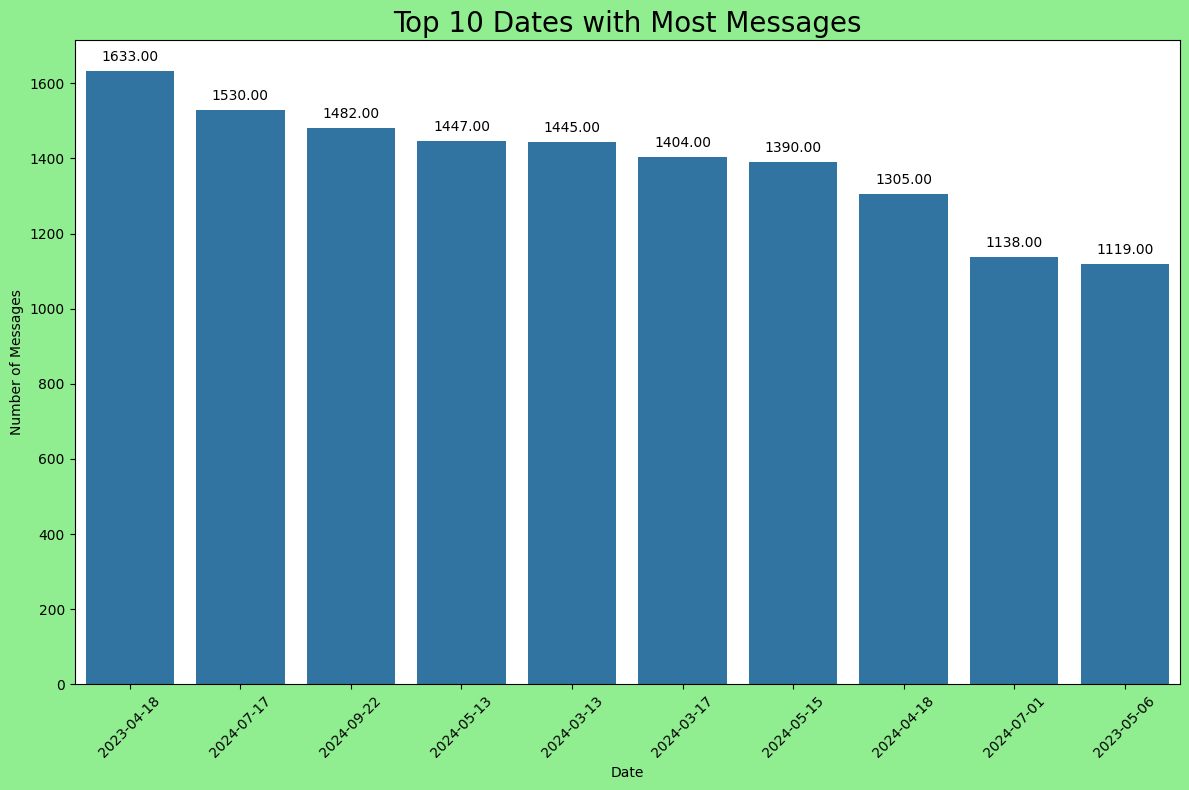

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')

date_counts = df.groupby('date')['message'].count()

top_10_dates = date_counts.nlargest(10)

plt.figure(figsize=(12, 8),facecolor='lightgreen')
ax = sns.barplot(x=top_10_dates.index, y=top_10_dates.values)
plt.xlabel("Date")
plt.ylabel("Number of Messages")
plt.title("Top 10 Dates with Most Messages", size=20)
plt.xticks(rotation=45)
plt.tight_layout()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.savefig('top10active.png')
plt.show()

Time-Series of Messaging Frequency and Months

In [ ]:
date_df = df.groupby("date")['message'].count().reset_index(name='message_count')
fig = px.line(date_df, x="date", y="message_count", title='Messaging Frequency')
fig.update_xaxes(nticks=20)
fig.update_layout(width=1200)

min_idx = date_df['message_count'].idxmin()
max_idx = date_df['message_count'].idxmax()
fig.add_annotation(x=date_df['date'][min_idx], y=date_df['message_count'][min_idx],
                   text="Global Minimum", showarrow=True, arrowhead=4)
fig.add_annotation(x=date_df['date'][max_idx], y=date_df['message_count'][max_idx],
                   text="Global Maximum", showarrow=True, arrowhead=4)

fig.show()

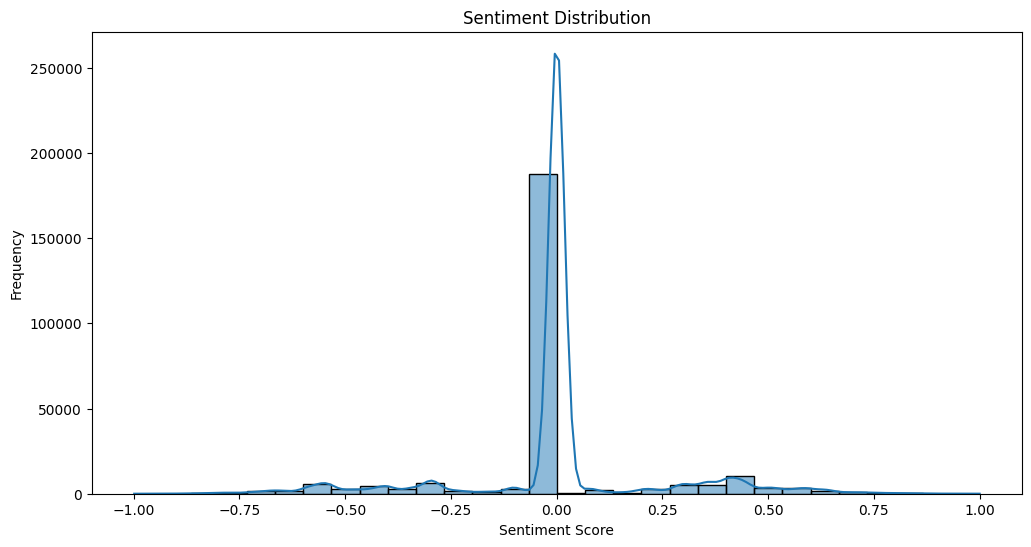

In [ ]:
#might not make a lot of sense as lexicon is for english and chat is substantially hindi
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['message'].apply(lambda x: sia.polarity_scores(x)['compound'])
plt.figure(figsize=(12, 6))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig('sentiment.png')
plt.show()

Finding distribution of Mentions

In [ ]:
from mentions import replace_mentions #replacing the phone numbers with aliases
df['mentions'] = replace_mentions(df['mentions'])

In [ ]:
df['mentions'].value_counts()

,count
mentions,
[],248072
[John5],926
[John10],885
[John3],797
[John2],668
...,...
"[John11, John9, John6, John12, John7, John1]",1
"[John9, John1, John12, John2, John7]",1
"[John5, John11, John3]",1


<ipython-input-80-ac5cbfff1b5a>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




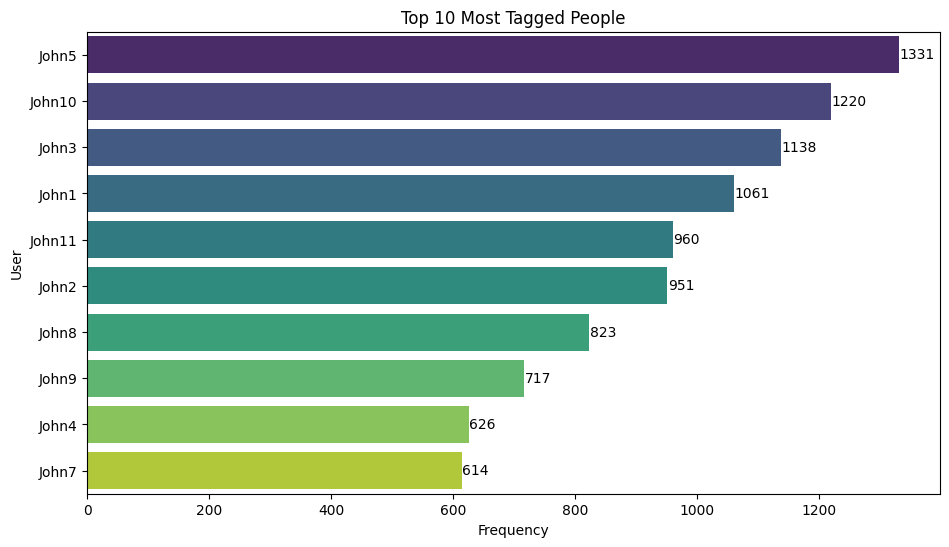

In [ ]:
# Flatten the list of mentions
all_mentions = [mention for sublist in df['mentions'] for mention in sublist]

mention_counts = Counter(all_mentions).most_common(10)

# Plot the most tagged people
tags, counts = zip(*mention_counts)
plt.figure(figsize=(11, 6))
ax = sns.barplot(x=list(counts), y=list(tags), palette='viridis')
plt.title('Top 10 Most Tagged People')
plt.xlabel('Frequency')
plt.ylabel('User')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1,
            p.get_y() + p.get_height() / 2,
            '{:1.0f}'.format(width),
            ha = 'left',
            va = 'center')

plt.show()